# Training a Logistic Regression model to predict the probability of wining for team1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('F:\\2019Spring\\march madness\\New folder\\comeon - Copy.csv')

In [4]:
mm_data.columns

Index(['team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc', 'num_ot',
       'team1_position', 'team2_position', 'team1_seed', 'team2_seed',
       ...
       'team1_quality_pt_career_overall_wins',
       'team1_quality_pt_career_overall_losses',
       'team1_quality_pt_team_season_wins',
       'team1_quality_pt_team_season_losses',
       'team2_quality_pt_career_school_wins',
       'team2_quality_pt_career_school_losses',
       'team2_quality_pt_career_overall_wins',
       'team2_quality_pt_career_overall_losses',
       'team2_quality_pt_team_season_wins',
       'team2_quality_pt_team_season_losses'],
      dtype='object', length=118)

In [5]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']


# Pythag College Basketball

#### E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [7]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

# Log 5

#### P(W) = (A - A B) / (A + B - 2A*B)

In [8]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))


In [9]:
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()


,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,111.4954,Alabama,2002,FL Atlantic,93.8770,0.878465,0.411542,0.911780
1,117.3877,Arizona,2002,Santa Barbara,96.9262,0.900485,0.707177,0.789333
2,118.5999,Duke,2002,Winthrop,87.7504,0.969660,0.367453,0.982148
3,109.6136,Indiana,2002,Utah,89.9224,0.906968,0.812015,0.692962
4,115.0406,Kansas,2002,Holy Cross,90.5399,0.940149,0.501475,0.939816


# Seed Diff

In [10]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [11]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id
0,2002-1104-1194,0.878465,0.411542,78,86,-88.820532,0.911780,1104,1194
1,2002-1112-1364,0.900485,0.707177,81,86,-697.542289,0.789333,1112,1364
2,2002-1181-1457,0.969660,0.367453,37,84,-191.666514,0.982148,1181,1457
3,2002-1231-1428,0.906968,0.812015,56,75,2148.977013,0.692962,1231,1428
4,2002-1242-1221,0.940149,0.501475,59,70,-39.535171,0.939816,1242,1221


# Split Data

In [12]:
mm_data.dropna(subset=['team1_log5'], inplace=True)
mm_data.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,...,team2_quality_pt_career_overall_losses,team2_quality_pt_team_season_wins,team2_quality_pt_team_season_losses,dist1,dist2,diff_dist,exp_win1,exp_win2,team1_log5,seed_diff
0,1104,86,1194,78,N,0,Y02,Y15,2,15,...,0.692308,0.633333,0.366667,970.079692,1058.900224,-88.820532,0.878465,0.411542,0.911780,-13
1,1112,86,1364,81,N,0,Z03,Z14,3,14,...,0.456140,0.666667,0.333333,513.690472,1211.232761,-697.542289,0.900485,0.707177,0.789333,-11
2,1181,84,1457,37,N,0,Y01,Y16,1,16,...,0.437853,0.689655,0.310345,148.431171,340.097686,-191.666514,0.969660,0.367453,0.982148,-15
3,1231,75,1428,56,N,0,Y05,Y12,5,12,...,0.437824,0.580645,0.419355,3008.248664,859.271651,2148.977013,0.906968,0.812015,0.692962,-7
4,1242,70,1221,59,N,0,X01,X16,1,16,...,0.341667,0.633333,0.366667,439.123404,478.658575,-39.535171,0.940149,0.501475,0.939816,-15


In [13]:
mm_data['team1_win'] = mm_data['outcome']
new_data = mm_data[['game_id','season','team1_win','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']]
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111 entries, 0 to 1110
Data columns (total 12 columns):
game_id        1111 non-null object
season         1111 non-null int64
team1_win      1111 non-null int64
exp_win1       1111 non-null float64
exp_win2       1111 non-null float64
team2_score    1111 non-null int64
team1_score    1111 non-null int64
diff_dist      1111 non-null float64
team1_log5     1111 non-null float64
team1_id       1111 non-null int64
team2_id       1111 non-null int64
seed_diff      1111 non-null int64
dtypes: float64(4), int64(7), object(1)
memory usage: 112.8+ KB


In [14]:
# 分层抽样 StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(new_data,new_data['team1_win']):
    strat_train_set = new_data.loc[train_index]
    strat_test_set = new_data.loc[test_index]

In [15]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(strat_train_set[['team1_log5']])

In [16]:
logit = LogisticRegression()
logit.fit(mm_train_scaled, strat_train_set['team1_win'])

C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
smlogit = sm.Logit(strat_train_set['team1_win'], strat_train_set['team1_log5']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.669863
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  888
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            0
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                 0.03359
Time:                        14:33:14   Log-Likelihood:                -594.84
converged:                       True   LL-Null:                       -615.51
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     0.7776      0.123      6.310      0.000       0.536       1.019
==============================================================================
"""

In [18]:
strat_test_set['preds'] = logit.predict_proba(scaler.fit_transform(strat_test_set[['team1_log5']]))[:,1]
strat_test_set['prediction'] = logit.predict(scaler.fit_transform(strat_test_set[['team1_log5']]))

In [19]:
strat_test_set[['team1_log5','team1_win','preds','prediction']]

,team1_log5,team1_win,preds,prediction
921,0.020880,0,0.059246,0
683,0.234438,0,0.176758,0
598,0.458681,0,0.437678,0
760,0.285620,0,0.223650,0
1016,0.125122,0,0.102818,0
57,0.749299,1,0.805102,1
676,0.575731,0,0.603879,1
589,0.494846,0,0.489280,0
527,0.413162,1,0.374721,0
716,0.488055,0,0.479539,0


In [20]:
strat_test_set.groupby('team1_win')['preds'].mean()

team1_win
0    0.374554
1    0.628021
Name: preds, dtype: float64

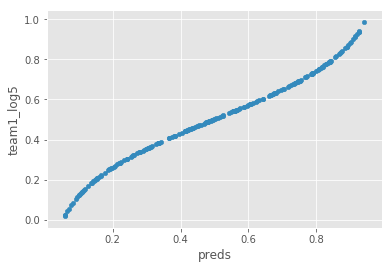

In [21]:
strat_test_set.plot(kind='scatter', x='preds',y='team1_log5')

In [22]:
log_loss(strat_test_set['team1_win'].values, strat_test_set['preds'].values)

0.5541293887200999

# Add Seed Difference & Distance

In [23]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(strat_train_set[['team1_log5','diff_dist','seed_diff']])

C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
logit = LogisticRegression()
logit.fit(mm_train_scaled, strat_train_set['team1_win'])

C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
smlogit = sm.Logit(strat_test_set['team1_win'], strat_test_set[['team1_log5','diff_dist','seed_diff']]).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.542020
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  223
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Mar 2019   Pseudo R-squ.:                  0.2180
Time:                        14:33:14   Log-Likelihood:                -120.87
converged:                       True   LL-Null:                       -154.57
                                        LLR p-value:                 2.315e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5    -0.0798      0.313     -0.255      0.799      -0.693       0.533
diff_dist  -4.045e-05      0.000     -0.300      0.764      -0.000       0.000
seed_diff     -0.1865      0.029     -6.434      0.000      -0.243      -0.130
==============================================================================
"""

In [26]:
strat_test_set['preds'] = logit.predict_proba(scaler.fit_transform(strat_test_set[['team1_log5','diff_dist','seed_diff']]))[:,1]
strat_test_set['prediction'] = logit.predict(scaler.fit_transform(strat_test_set[['team1_log5','diff_dist','seed_diff']]))

C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
log_loss(strat_test_set['team1_win'].values, strat_test_set['preds'].values)

0.545085003380442

In [28]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

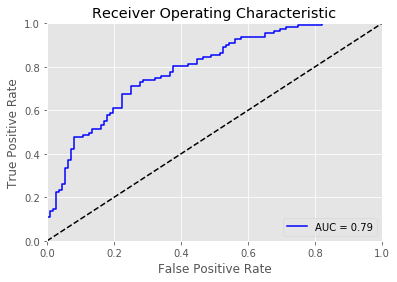

In [29]:
fpr, tpr, thresholds = roc_curve(strat_test_set['team1_win'].values, strat_test_set['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

# predict 2019 probability

In [30]:
data_2019 = pd.read_csv('F:\\2019Spring\\march madness\\NCAA_Tourney_2019.csv')

In [31]:
data_2019['dist1'] = data_2019.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
data_2019['dist2'] = data_2019.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [32]:
data_2019['diff_dist'] = data_2019['dist1'] - data_2019['dist2']

In [33]:
data_2019['exp_win1'] = (data_2019['team1_adjoe']**11.5)/ ((data_2019['team1_adjde']**11.5)+(data_2019['team1_adjoe']**11.5))
data_2019['exp_win2'] = (data_2019['team2_adjoe']**11.5)/ ((data_2019['team2_adjde']**11.5)+(data_2019['team2_adjoe']**11.5))

In [34]:
data_2019['team1_log5'] = (data_2019['exp_win1'] - (data_2019['exp_win1']*data_2019['exp_win2']))/ (data_2019['exp_win1']+data_2019['exp_win2']-(2*data_2019['exp_win1']*data_2019['exp_win2']))


In [35]:
data_2019[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()


,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,120.204,Duke,2019,Michigan St,88.2449,0.972195,0.967555,0.539696
1,120.204,Duke,2019,LSU,88.2449,0.972195,0.903836,0.788141
2,120.204,Duke,2019,Virginia Tech,88.2449,0.972195,0.934524,0.710126
3,120.204,Duke,2019,Mississippi St,88.2449,0.972195,0.902412,0.790848
4,120.204,Duke,2019,Maryland,88.2449,0.972195,0.901775,0.792038


In [36]:
data_2019['seed_diff'] = data_2019['team1_seed'] - data_2019['team2_seed']

In [37]:
data_2019[['game_id','exp_win1','exp_win2','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,diff_dist,team1_log5,team1_id,team2_id
0,2019-1181-1277,0.972195,0.967555,-392.744268,0.539696,1181,1277
1,2019-1181-1261,0.972195,0.903836,-1233.942817,0.788141,1181,1261
2,2019-1181-1439,0.972195,0.934524,13.437605,0.710126,1181,1439
3,2019-1181-1280,0.972195,0.902412,-860.279602,0.790848,1181,1280
4,2019-1181-1268,0.972195,0.901775,350.370210,0.792038,1181,1268


## set null as median

In [38]:
data_2019.isna().sum()

game_id                              0
team1_id                             0
team2_id                             0
season                               0
team1_seed                           0
team2_seed                           0
team1_position                       0
team2_position                       0
strongseed                           0
weakseed                             0
team1_region                         0
team2_region                         0
slot                                 0
host                                 1
host_lat                             1
host_long                            1
team1_teamname                       0
team2_teamname                       0
team1_coach_id                       0
team1_coach_name                     0
team1_pt_school_ncaa                 0
team1_pt_overall_ncaa                0
team1_pt_school_s16                  0
team1_pt_overall_s16                 0
team1_pt_school_ff                   0
team1_pt_overall_ff      

In [39]:
data_2019_new = data_2019[['game_id','exp_win1','exp_win2','diff_dist','team1_log5','team1_id','team2_id','seed_diff']]
data_2019_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 8 columns):
game_id       2278 non-null object
exp_win1      2278 non-null float64
exp_win2      2278 non-null float64
diff_dist     2277 non-null float64
team1_log5    2278 non-null float64
team1_id      2278 non-null int64
team2_id      2278 non-null int64
seed_diff     2278 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 142.5+ KB


In [40]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

C:\Users\Qing Chen\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
data_2019_new_num = data_2019_new.drop('game_id',axis=1)
imputer.fit(data_2019_new_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [42]:
data_2019_new_X = imputer.transform(data_2019_new_num)
data_2019_new_df = pd.DataFrame(data_2019_new_X, columns = data_2019_new_num.columns)
data_2019_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 7 columns):
exp_win1      2278 non-null float64
exp_win2      2278 non-null float64
diff_dist     2278 non-null float64
team1_log5    2278 non-null float64
team1_id      2278 non-null float64
team2_id      2278 non-null float64
seed_diff     2278 non-null float64
dtypes: float64(7)
memory usage: 124.7 KB


In [43]:
data_2019_result = pd.concat([data_2019['game_id'],data_2019_new_df],axis=1)
data_2019_result

,game_id,exp_win1,exp_win2,diff_dist,team1_log5,team1_id,team2_id,seed_diff
0,2019-1181-1277,0.972195,0.967555,-392.744268,0.539696,1181.0,1277.0,-1.0
1,2019-1181-1261,0.972195,0.903836,-1233.942817,0.788141,1181.0,1261.0,-2.0
2,2019-1181-1439,0.972195,0.934524,13.437605,0.710126,1181.0,1439.0,-3.0
3,2019-1181-1280,0.972195,0.902412,-860.279602,0.790848,1181.0,1280.0,-4.0
4,2019-1181-1268,0.972195,0.901775,350.370210,0.792038,1181.0,1268.0,-5.0
5,2019-1181-1257,0.972195,0.913200,-398.371878,0.768704,1181.0,1257.0,-6.0
6,2019-1181-1433,0.972195,0.866668,204.359048,0.843241,1181.0,1433.0,-7.0
7,2019-1181-1416,0.972195,0.836085,-849.285350,0.872692,1181.0,1416.0,-8.0
8,2019-1181-1278,0.972195,0.833312,-1133.657272,0.874908,1181.0,1278.0,-9.0
9,2019-1181-1125,0.972195,0.800207,-549.868266,0.897225,1181.0,1125.0,-10.0


### Standardization 

In [44]:
data_2019_scaled = scaler.fit_transform(data_2019_result[['team1_log5','diff_dist','seed_diff']])

In [45]:
data_2019_result['prob'] = logit.predict_proba(data_2019_scaled)[:,1]
data_2019_result['prediction'] = logit.predict(data_2019_scaled)

In [46]:
save_one = data_2019_result[['game_id','prob']]
save_one.head()

,game_id,prob
0,2019-1181-1277,0.512974
1,2019-1181-1261,0.755990
2,2019-1181-1439,0.671867
3,2019-1181-1280,0.765882
4,2019-1181-1268,0.743957


In [47]:
save_one.to_csv('F:\\2019Spring\\march madness\\second\\Zalda.csv',index=False)